# import

In [1]:
import random
import csv
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import preprocessing
import matplotlib.pyplot as plt

# define

In [21]:
# ボタンの種類数
BUTTON_NUM = 300
# 明度
BRIGHTNESS = [40, 50, 60]
# 彩度
SATURATION = [20, 40, 60, 80]
# 角の丸み
ROUNDNESS = [0, 1, 2, 3, 5]
# 飛び出し具合
POPOUT = [0, 3, 6, 9, 12]
# k値
K = 40
# k値を変化させるとき用
KS = list(range(1, 101))
# 検証時N回平均をとる
N = 100

# 対戦表ファイル
BATTLE_TABLE_FILE = './data/batle_table.txt'
# クラウドソーシングのタスク発行用TSV
CROWDSOURCING_QUESTION_FILE = './data/crowdsourcing_question.tsv'
# クラウドソーシングの結果
CROWDSOURCING_RESULT_FILE = './data/crowdsourcing_result.txt'

# クラウドソーシングタスクを作る
ランダム性があるのでタスクを投げた後は再実行しないこと

In [3]:
# 対戦表を作る
# タスク発効後は絶対に再実行しないこと
# battle_table = [(1, 2), (1, 5), ...]
def create_battle_table():
    battle_time = [0] * BUTTON_NUM # 被ジャッジ回数
    battle_table = []
    for i in range(BUTTON_NUM):
        # 対戦したことある相手を保存
        have_battled = []
        while battle_time[i] < 3:
            # 被ジャッジ回数が3回未満なら対戦相手を決める
            # 対戦相手となりうるデータ
            tmp = []
            if i+1 < BUTTON_NUM - 1:
                for g in range(i+1, BUTTON_NUM):
                    # 自分よりインデックスが大きい要素を参照
                    if battle_time[g] < 3:
                        tmp.append(g)
                    # 過去に対戦した相手はtmpから外す
                    if len(have_battled) > 0:
                        for h in have_battled:
                            if h in tmp:
                                tmp.remove(h)
            # 対戦相手となりうるデータからランダムに対戦相手を決める
            if len(tmp) > 0:
                opponent = random.choice(tmp)
                have_battled.append(opponent)
                battle_table.append((i, opponent))
                # 被ジャッジ回数を加算
                battle_time[i] += 1
                battle_time[opponent] += 1
            else:
                # まだ3回戦えていないのに対戦可能な相手がいない
                break
    return battle_table

# 対戦表をシャッフル
def shuffle_battle_table(battle_table):
    return random.sample(battle_table, len(battle_table))

# 対戦表をファイル出力
def battle_table_to_file(battle_table):
    file = open(BATTLE_TABLE_FILE, 'w')
    for battle in battle_table:
        file.write(battle[0] + ' ' + battle[1] + '\n')
        
# ファイルから対戦表を読み込み
def battle_table_from_file():
    battle_table = []
    file = open(BATTLE_TABLE_FILE, 'r')
    for line in file:
        line = line.rstrip('\n')
        tmp = line.split()
        battle_table.append((tmp[0], tmp[1]))
        
    return battle_table

# 設問データ(TSVファイル出力)
def create_crowd_sourcing(battle_table):
    # データ生成
    # 画像は大学のウェブサーバにおいておく(ワーカからも参照できるようにするため)
    url = 'https://www.u.tsukuba.ac.jp/~s2010780/experimentA/image/{}.png'
    qe = '直感で「クリックしたいと思った」ボタンを選んでください'
    msg = '提示されているボタンをクリックして選択するのではなく、ボタン画像の下にある白いボタンをクリックして選択してください。'
    tsv_data = []
    for i, v in enumerate(battle_table):
        row = []
        # 設問ID(半角英数字20文字以内)
        row.append(i)
        # チェック設問有無(0:無 1:有)
        row.append(0)
        # チェック設問の解答(F04用)
        row.append('')
        # チェック設問の解答(F07用)
        row.append('')
        # F01:ラベル
        row.append(qe)
        # F02:ラベル
        row.append('ボタン1')
        # F03:画像（ＵＲＬ）
        row.append(url.format(v[0]))	
        # F04:選択ボタン
        row.append('ボタン1')
        # F05:ラベル
        row.append('ボタン2')
        # F06:画像（ＵＲＬ）
        row.append(url.format(v[1]))
        # F07:選択ボタン
        row.append('ボタン2')
        # F08:ラベル
        row.append(msg)
        
        tsv_data.append(row)


    # データ出力
    f = open(CROWDSOURCING_QUESTION_FILE, 'w', encoding='utf-8', newline='')
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(tsv_data)
    f.close()

In [4]:
# 再実行防止のためコメントアウト-----------------

# # 対戦表を作る
# battle_table = create_battle_table()
# shuffle_battle_table(battle_table)
# # 対戦表をファイルに保存しておく
# battle_table_to_file(battle_table)

# # ファイルから対戦表を読み込む
# battle_table = battle_table_from_file()
# create_crowd_sourcing(battle_table)

#-------------------------------------------

# データを作る

In [6]:
# 非正規化データ
def create_data():
    brightness = BRIGHTNESS
    saturation = SATURATION
    roundness = ROUNDNESS
    popout = POPOUT

    button_no = 0
    data = []
    for b in brightness:
        for s in saturation:
            for r in roundness:
                for p in popout:
                    data.append([button_no, b, s, r, p])
                    button_no += 1

    return data

# 正規化データ
def create_normalized_data():
    brightness = preprocessing.minmax_scale(BRIGHTNESS)
    saturation = preprocessing.minmax_scale(SATURATION)
    roundness = preprocessing.minmax_scale(ROUNDNESS)
    popout = preprocessing.minmax_scale(POPOUT)

    button_no = 0
    data = []
    for b in brightness:
        for s in saturation:
            for r in roundness:
                for p in popout:
                    data.append([button_no, b, s, r, p])
                    button_no += 1

    return data

# クラウドソーシングの結果
納品データは手動で整形してcrowdsourcing_result.txtとして保存

In [7]:
# 納品データの受け取り
# resules = [(ボタンNo, ボタンNo, ワーカ1の解答, ワーカ2の解答)]
def get_crowd_sourcing():
    cs_results = []

    f = open(CROWDSOURCING_RESULT_FILE, 'r')
    i = 0
    while True:
        line = f.readline()
        if line == '':
            break
        line = str(line).strip()
        line_li = line.split(',')
        if i % 2 == 0:
            tmp = line_li[3]
        else:
            cs_results.append((int(line_li[1]), int(line_li[2]), int(tmp), int(line_li[3])))
        i += 1
    f.close()

    return cs_results

# ワーカーを測る
def get_agreement_ratio(cs_results):
    qe_num = len(cs_results)
    same_num = 0
    for result in cs_results:
        if result[2] == result[3]:
            same_num += 1
    agreement_ratio = same_num / qe_num * 100

    # 出力
    print('問題数(種類): {}'.format(qe_num))
    print('ふたりのワーカーの解答が一致していた問題数: {}'.format(same_num))
    print('ワーカー間の解答一致率 (agreement_ratio): {}%'.format(agreement_ratio))

    return agreement_ratio

# データにラベルを付ける

In [8]:
# 各ボタンの持ち点を算出
def get_points(cs_results):
    points = [0] * BUTTON_NUM # ボタンNoがインデックスと対応
    for cs_result in cs_results:
        # ワーカー1
        if cs_result[2] == 1:
            points[cs_result[0]] += 1
            points[cs_result[1]] -= 1
        else:
            points[cs_result[0]] -= 1
            points[cs_result[1]] += 1
        # ワーカー2
        if cs_result[3] == 1:
            points[cs_result[0]] += 1
            points[cs_result[1]] -= 1
        else:
            points[cs_result[0]] -= 1
            points[cs_result[1]] += 1

    return points

# 持ち点をラベルに持つデータ
def create_data_points(data, points):
    data_points = []
    for li in data:
        data_points.append([li[0], li[1], li[2], li[3], li[4], points[li[0]]])

    return data_points

# 押したいか押したくないかをラベルの持つデータ
def create_data_2labels(data, points):
    data_2labels = []
    for li in data:
        if points[li[0]] > 0:
            data_2labels.append([li[0], li[1], li[2], li[3], li[4], 1])
        else:
            data_2labels.append([li[0], li[1], li[2], li[3], li[4], 0])

    return data_2labels

# ラベル付け
def create_labeling_data(data, points, data_type):
    if data_type == '2labels':
        return create_data_2labels(data, points)
    elif data_type == 'points':
        return create_data_points(data, points)

# 機械学習

In [9]:
# データをデータフレーム化
def create_dataframe(data):
    columns =['button_no', 'brightness', 'saturation', 'roundness', 'popout', 'class']
    df = pd.DataFrame(data = data, columns = columns)

    return df

# 機械学習
def ml(df, k):
    # データをシャッフル
    df = df.sample(frac=1).reset_index(drop=True)

    # データの切り分け
    # 教師 : テスト = 8 : 2
    train_rate = int(df.shape[0] * 0.8)
    train_data = df.iloc[:train_rate, :]
    test_data = df.iloc[train_rate:, :]
    test_button_no = test_data.iloc[:, 0].values

    # パラメータがどの列か指定
    params = list(range(df.shape[1]))[1:-1]
    
    # knnインスタンス生成
    knn = KNN(n_neighbors = k, n_jobs = -1)
    
    # 教師データセット(学習)
    knn.fit(
        X = train_data.iloc[:, params].values,
        y = train_data["class"].values,
    )
    
    #テストデータをクラス分類
    predict = knn.predict(
        X = test_data.iloc[:, params].values, 
    )
    
    re = []
    for i in range(len(predict)):
        re.append([test_button_no[i], predict[i]])
    
    # 認識率
    acc = sum(test_data["class"] == predict) / len(predict) * 100

    return {'ml_results': re, 'acc': acc}

# 認識率のn回平均をとる
def acc_average(n, df, k):
    sum = 0
    for i in range(n):
        sum += ml(df, k)['acc']
    return sum / n

# kの値を変化させる
def change_k(n, df):
    re = []
    for k in KS:
        re.append(acc_average(n, df, k))

    return re

# 結果出力
# 機械学習を一回行った結果
def show_ml_results(df, k, data_type):
    re = ml(df, k)
    if data_type == '2labels':
        for result in re['ml_results']:
            if result[1] == 0:
                print('{} -> そうでもない'.format(result[0]))
            else:
                print('{} -> 押したい'.format(result[0]))
    elif data_type == 'points':
        print('12点満点')
        for result in re['ml_results']:
            print('{} -> {}点'.format(result[0], result[1]+6))

    print('認識率は{}%でした'.format(re['acc']))

# 認識率(n回平均)
def show_acc_average(n, df, k):
    re = acc_average(n, df, k)
    print('機械学習{}回実行時の平均認識率は{}%でした'.format(n, re))

# kの値を変化させたときのグラフ
def show_change_k(n, df):
    x = KS
    y = change_k(n, df)

    plt.plot(x, y)
    plt.xlabel('k', color='white')
    plt.ylabel('Recognition rate', color='white')
    plt.xticks(color='white')
    plt.yticks(color='white')

    plt.show()

    y_max = max(y)
    print('最高認識率 {}% (k={})'.format(y_max, y.index(y_max)+1))

# execute

In [10]:
# データの種を用意
data_r = create_data()
data_n = create_normalized_data()

In [11]:
# ファイルからクラウドソーシングの結果を取得
cs_results = get_crowd_sourcing()

In [12]:
# agreement_ratioを求める
agreement_ratio = get_agreement_ratio(cs_results)

問題数(種類): 450
ふたりのワーカーの解答が一致していた問題数: 306
ワーカー間の解答一致率 (agreement_ratio): 68.0%


In [13]:
# データにラベル付け
points = get_points(cs_results)
data_r_points = create_labeling_data(data_r, points, 'points')
data_r_2labels = create_labeling_data(data_r, points, '2labels')
data_n_points = create_labeling_data(data_n, points, 'points')
data_n_2labels = create_labeling_data(data_n, points, '2labels')

In [14]:
# データをデータフレーム化
df_r_points = create_dataframe(data_r_points)
df_r_2labels = create_dataframe(data_r_2labels)
df_n_points = create_dataframe(data_n_points)
df_n_2labels = create_dataframe(data_r_2labels)

In [18]:
# 判定アプリケーションを1回動かす
#show_ml_results(df_r_points, K, 'points')
#show_ml_results(df_r_2labels, K, '2labels')
#show_ml_results(df_n_points, K, 'points')
show_ml_results(df_n_2labels, K, '2labels')

182 -> 押したい
4 -> そうでもない
236 -> そうでもない
74 -> 押したい
258 -> 押したい
39 -> そうでもない
172 -> 押したい
5 -> そうでもない
57 -> 押したい
122 -> そうでもない
17 -> そうでもない
270 -> そうでもない
44 -> そうでもない
95 -> 押したい
53 -> 押したい
73 -> 押したい
203 -> そうでもない
126 -> そうでもない
255 -> 押したい
154 -> 押したい
21 -> そうでもない
6 -> そうでもない
218 -> そうでもない
241 -> そうでもない
175 -> 押したい
133 -> そうでもない
226 -> そうでもない
42 -> そうでもない
262 -> 押したい
101 -> そうでもない
98 -> 押したい
10 -> そうでもない
148 -> そうでもない
290 -> 押したい
41 -> そうでもない
131 -> そうでもない
188 -> 押したい
168 -> 押したい
213 -> そうでもない
223 -> そうでもない
235 -> そうでもない
178 -> 押したい
265 -> 押したい
34 -> そうでもない
155 -> 押したい
75 -> 押したい
113 -> そうでもない
160 -> 押したい
267 -> 押したい
196 -> 押したい
125 -> そうでもない
259 -> そうでもない
130 -> そうでもない
159 -> 押したい
9 -> そうでもない
121 -> そうでもない
112 -> そうでもない
292 -> 押したい
271 -> 押したい
24 -> そうでもない
認識率は75.0%でした


In [19]:
# 認識率を求める
show_acc_average(N, df_r_points, K)
show_acc_average(N, df_r_2labels, K)
show_acc_average(N, df_n_points, K)
show_acc_average(N, df_n_2labels, K)

機械学習100回実行時の平均認識率は26.66666666666665%でした
機械学習100回実行時の平均認識率は74.26666666666665%でした
機械学習100回実行時の平均認識率は25.90000000000001%でした
機械学習100回実行時の平均認識率は74.63333333333335%でした


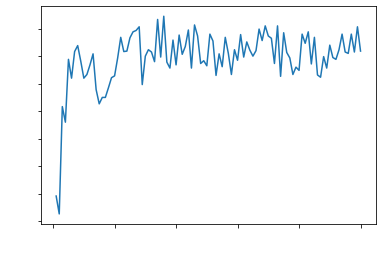

最高認識率 75.44999999999999% (k=36)


In [23]:
# 適切なk値の検証
# show_change_k(N, df_r_points)
# show_change_k(N, df_r_2labels)
# show_change_k(N, df_n_points)
show_change_k(N, df_n_2labels)